In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Activation, UpSampling2D, Dropout, BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras import activations, Sequential
import graphviz

2024-01-04 18:11:51.562471: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 18:11:52.118500: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 18:11:52.125514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 18:11:54.061537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
class Generator:
    
    def __init__(self, shape_of_image) :
        self.input_layer = Input(shape=shape_of_image)
        self.previous_layer = self.input_layer
        
        # downsampling
        d1 = self.downsample(64, 4)
        d2 = self.downsample(128, 4) 
        d3 = self.downsample(256, 4) 
        d4 = self.downsample(512, 4) 
        d5 = self.downsample(512, 4) 
        d6 = self.downsample(512, 4) 
        d7 = self.downsample(512, 4) 
        d8 = self.downsample(512, 4) 
        
        # upsampling
        self.upsample(512, 4, d7,  dropout_rate=0.5) 
        self.upsample(512, 4, d6,  dropout_rate=0.5) 
        self.upsample(512, 4, d5,  dropout_rate=0.5) 
        self.upsample(512, 4, d4) 
        self.upsample(256, 4, d3) 
        self.upsample(128, 4, d2) 
        self.upsample(64,  4, d1) 
        
        self.output_layer = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(self.previous_layer)
        self.model = keras.Model(inputs=self.input_layer, outputs=self.output_layer, name="Generator(U-Net)")
        
    
    def downsample(self, filters, kernel_size):
        sequential = Sequential()
        initializer = tf.random_normal_initializer(0., 0.02)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, padding='same', kernel_initializer=initializer)
        sequential.add(conv)
        norm = BatchNormalization()
        sequential.add(norm)
        relu = Activation(activations.relu)
        sequential.add(relu)
        self.previous_layer = sequential(self.previous_layer)
        return self.previous_layer
    
    def upsample(self, filters, kernel_size, skip_layer=None, dropout_rate=0.0):
        initializer = tf.random_normal_initializer(0., 0.02)
        sequential = Sequential()
        conv_transpose = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same', kernel_initializer=initializer)
        sequential.add(conv_transpose)
        norm = BatchNormalization()
        sequential.add(norm)
        if (dropout_rate > 0) :
            dropout = Dropout(dropout_rate)
            sequential.add(dropout)
            
        relu = Activation(activations.relu)
        sequential.add(relu)
        self.previous_layer = sequential(self.previous_layer)
        if skip_layer is not None:
            self.previous_layer = tf.keras.layers.Concatenate()([self.previous_layer, skip_layer])
       

In [12]:
generator = Generator((256, 256, 3)).model

In [13]:
generator.summary()

Model: "Generator(U-Net)"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_40 (Sequential)  (None, 128, 128, 64)         3392      ['input_4[0][0]']             
                                                                                                  
 sequential_41 (Sequential)  (None, 64, 64, 128)          131712    ['sequential_40[0][0]']       
                                                                                                  
 sequential_42 (Sequential)  (None, 32, 32, 256)          525568    ['sequential_41[0][0]']       
                                                                                   

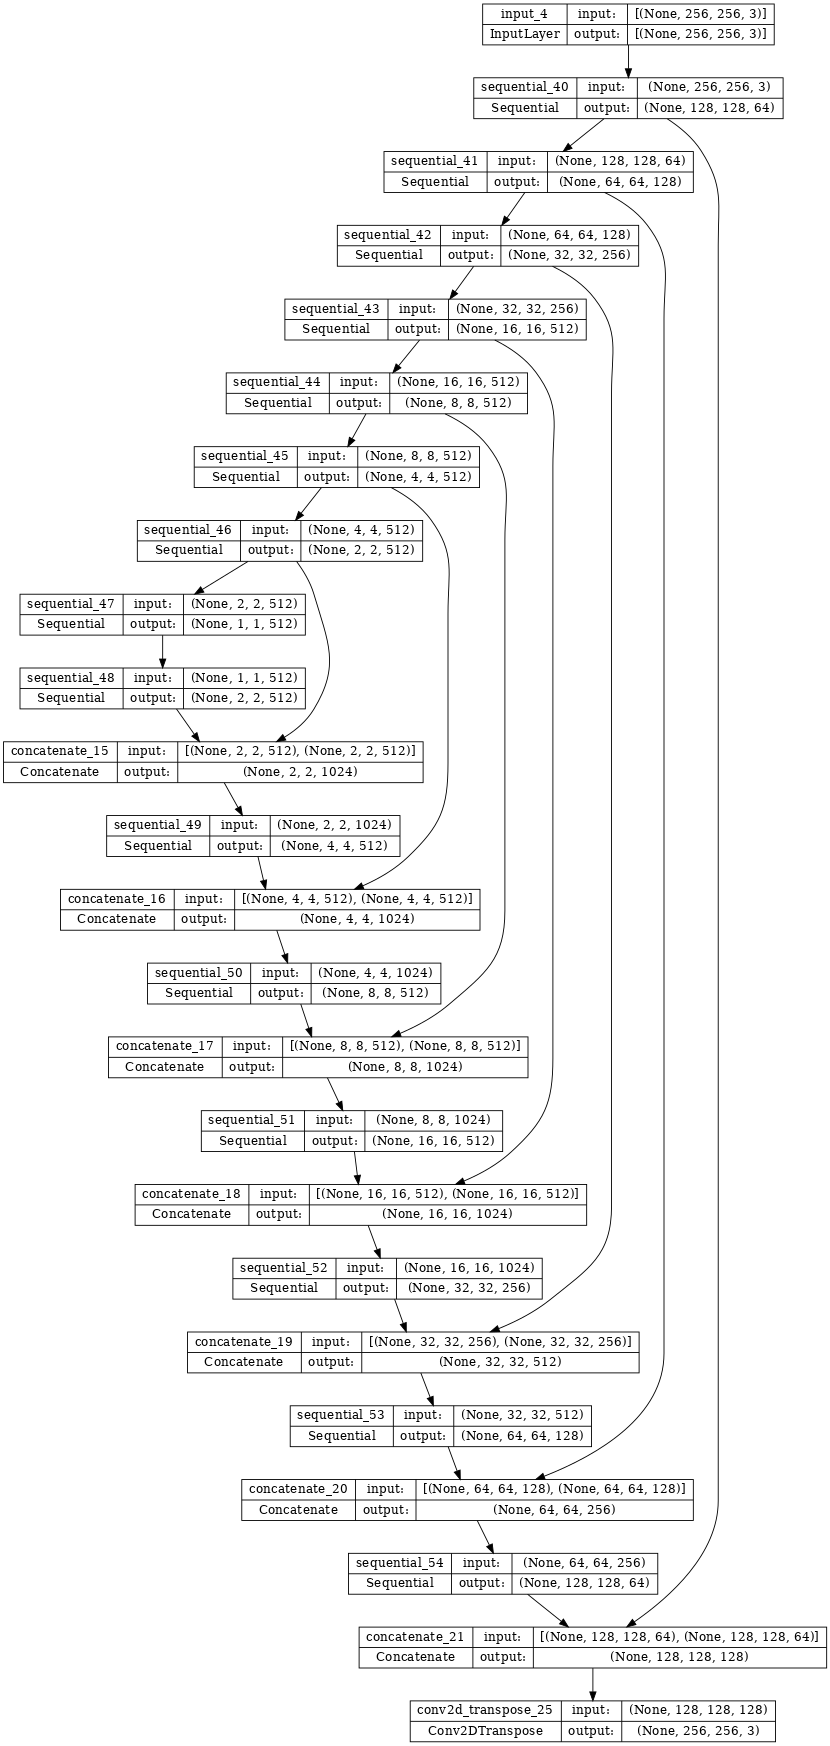

In [17]:
keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='../images/generatorModel.png')